In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from glob import glob
from pprint import pprint


## Config Session
### This session contains static information essential to the code

In [49]:
PATH_FILE = 'data/acc'
PATH_FILE_METRICS_OUTPUT = 'data/metrics_acc'

SELECTOR = [
    'NEW_PROB', 'year', 'border', 'PESO_AMOS','POINTEDITE',
    'AMOSTRAS','REINSP','NEW_PROB','ADJ_FACTOR','PESO_VOT'
]

REMAP_CLASSES = {
    'reference': {6: 3},
    'classification': {6: 3}
}

# 0 - no, 1 - yes
ACCEPT_BORDER = 0

YEARS = list(range(1985, 2022, 1))

CLASSES = {
    3: 'Forest',
    4: 'Shrubland',
    # 6: 'Flooded Forest',
    11: 'Wetland',
    12: 'Natural Grassland',
    15: 'Pastureland',
    18: 'Cropland',
    #22: 'Bareland and Impervious',
    #29: 'Rock Outcrop',
    33: 'Water'
}


## Input Data
### This session we load the input data, files to perform calculations

In [50]:
df_samples = pd.concat([pd.read_csv(x) for x in glob(PATH_FILE + '/*')])
df_samples = df_samples[[
    'reference', 'classification', 'year', 'border',
    'BIOMA', 'AMOSTRAS']]


df_samples = df_samples.query(f'border == {ACCEPT_BORDER}') \
    if ACCEPT_BORDER == 0 else df_samples

df_samples = df_samples.query('AMOSTRAS != "Treinamento"')
 

# remap classes
df_samples = df_samples.replace({
    'reference': REMAP_CLASSES['reference'],
    'classification': REMAP_CLASSES['classification'],
})

# filter samples
df_samples = df_samples.loc[df_samples['reference'].isin(CLASSES.keys())]
df_samples = df_samples.loc[df_samples['classification'].isin(CLASSES.keys())]



## Number of Samples

In [51]:

{

    # total de amostras no asset original
    'total_samples': 35.289,
    'total_validation_samples': 25.413,

    # total de amostras após a exportação
    # ligeira diferença devido aos limite do bioma Amazônia usado
    'total_samples_exported': 35.260,
    'total_validation_samples_exported': 25.392,

    # total de amostras ao filtrar o dataset REMOVENDO amostras
    # da classe Não Observado. O comportamente do nº total de amostras
    # vai apresentar um ligeiro dinamismo ao longo dos anos variando de 
    # acordo com o nº de amostras filtradas. 
    'total_samples_w_non_observed': 33.146,
    'total_validation_samples_exported_w_non_observed': 23.848,

    # total de amostras após filtrar o dataset REMOVENDO a classe Não Observado
    # e considerando apenas amostras que NÃO ESTÃO em bordas de diferentes alvos. 
    # O comportamente do nº total de amostras vai apresentar um ligeiro dinamismos
    # variando ao longo dos anos de acordo com 2 fatores: nº de amostras filtradas 
    # nº de amostras que estão em bordas no ano
    'total_samples_w_non_observed_w_border': 31.316,
    'total_validation_samples_exported_w_non_observed_w_border': 22.464,

}

{'total_samples': 35.289,
 'total_validation_samples': 25.413,
 'total_samples_exported': 35.26,
 'total_validation_samples_exported': 25.392,
 'total_samples_w_non_observed': 33.146,
 'total_validation_samples_exported_w_non_observed': 23.848,
 'total_samples_w_non_observed_w_border': 31.316,
 'total_validation_samples_exported_w_non_observed_w_border': 22.464}

## Helper Functions
### Auxiliar functions

In [52]:
def calculate_metrics(confusion_matrix, classes):

    accuracy_user = {}
    accuracy_producer = {}
    precision = {}
    recall = {}
    f1_score = {}
    comission_error = {}
    omission_error = {}




    for class_name in classes.values():
        class_index = df.index.get_loc(class_name)

        true_positive = confusion_matrix.iloc[class_index, class_index]
        false_positive = confusion_matrix.iloc[class_index, :].sum() - true_positive
        false_negative = confusion_matrix.iloc[:, class_index].sum() - true_positive

        comission_error[class_name] = false_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
        omission_error[class_name] = false_negative / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0

        accuracy_user[class_name] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
        accuracy_producer[class_name] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
        

        precision[class_name] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
        recall[class_name] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
        f1_score[class_name] = 2 * (precision[class_name] * recall[class_name]) / (precision[class_name] + recall[class_name]) if (precision[class_name] + recall[class_name]) != 0 else 0

    return accuracy_user, accuracy_producer, precision, recall, f1_score, comission_error, omission_error



## Get Metrics of Accuracy
### overall acc, producer, user, precision, recall, f1-score

In [53]:

overall_acc = []

for year in YEARS:

    df_samples_year = df_samples.query(f'year == {year}')



    # get reference and predicted lists
    y_true = np.array(df_samples_year[['reference']].values).flatten()
    y_pred = np.array(df_samples_year[['classification']].values).flatten()



    # get confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    # matrix_transposed = matrix.transpose()



    # get total samples of each class
    total_samples = [sum(row) for row in matrix]
    total_samples_cls = list(zip(CLASSES.values(), total_samples))



    # calculate percentages for each element in the confusion matrix
    percentage_data = [[value / total_samples[i] * 100 for value in row] for i, row in enumerate(matrix)]



    # create DataFrame with data percentage
    df_percentage = pd.DataFrame(
        percentage_data, 
        columns=[CLASSES[key] for key in CLASSES.keys()], index=[CLASSES[key] for key in CLASSES.keys()]
    )


    # create DataFrame with data keys
    df = pd.DataFrame(
        matrix, 
        columns=[CLASSES[key] for key in CLASSES.keys()], index=[CLASSES[key] for key in CLASSES.keys()]
    )


    accuracy_user, accuracy_producer, \
    precision, recall, f1_score, comission_error, omission_error = calculate_metrics(df, CLASSES)



    # now get overall accuracy
    total_correct = sum([matrix[i][i] for i in range(len(matrix))])
    total_samples = np.sum(matrix)
    global_accuracy = total_correct / total_samples



    overall_acc.append(global_accuracy)

    
    # add accuracy and metrics columns to the DataFrame
    df_percentage['Accuracy User'] = [round(accuracy_user[class_name], 2) for class_name in df.index]
    df_percentage['Accuracy Producer'] = [round(accuracy_producer[class_name], 2) for class_name in df.index]
    df_percentage['Precision'] = [round(precision[class_name], 2) for class_name in df.index]
    df_percentage['Recall'] = [round(recall[class_name], 2) for class_name in df.index]
    df_percentage['F1-Score'] = [round(f1_score[class_name], 2) for class_name in df.index]
    df_percentage['Comission Error'] = [round(comission_error[class_name], 2) for class_name in df.index]
    df_percentage['Omission Error'] = [round(omission_error[class_name], 2) for class_name in df.index]

    df_percentage = df_percentage.round(2)


    # add sum of collums and rows
    df['Total'] = [df.loc[cls_name].sum() for cls_name in CLASSES.values()]
    df.loc['Total'] = [df.loc[:, x].sum() for x in df.index] + [df['Total'].sum()]
    


    # output names
    name_cm_percentage = f'confusion_matrix_percentage_{year}.csv'
    name_cm = f'confusion_matrix_{year}.csv'
    name_metrics = f'metrics_{year}.csv'

    #  save tables
    df_percentage[CLASSES.values()].to_csv(PATH_FILE_METRICS_OUTPUT + '/' + name_cm_percentage)
    df.to_csv(PATH_FILE_METRICS_OUTPUT + '/' + name_cm)
    df_percentage[[
        'Accuracy User',
        'Accuracy Producer',
        # 'Precision',
        # 'Recall',
        # 'F1-Score',
        'Comission Error',
        'Omission Error'
    ]].to_csv(PATH_FILE_METRICS_OUTPUT + '/' + name_metrics)

df_overall_acc = pd.DataFrame({'year': YEARS, 'acc': overall_acc})

df_overall_acc.to_csv(PATH_FILE_METRICS_OUTPUT + '/' + 'overall_acc.csv')

In [54]:
df

,Forest,Shrubland,Wetland,Natural Grassland,Pastureland,Cropland,Water,Total
Forest,16317,24,78,76,224,3,11,16733
Shrubland,61,35,50,103,16,0,0,265
Wetland,30,9,159,38,3,0,14,253
Natural Grassland,27,7,173,420,8,0,0,635
Pastureland,296,24,20,94,3015,45,0,3494
Cropland,29,1,3,17,166,337,0,553
Water,19,1,13,5,3,0,351,392
Total,16779,101,496,753,3435,385,376,22325


In [55]:
df_percentage[CLASSES.values()]

,Forest,Shrubland,Wetland,Natural Grassland,Pastureland,Cropland,Water
Forest,97.51,0.14,0.47,0.45,1.34,0.02,0.07
Shrubland,23.02,13.21,18.87,38.87,6.04,0.00,0.00
Wetland,11.86,3.56,62.85,15.02,1.19,0.00,5.53
Natural Grassland,4.25,1.10,27.24,66.14,1.26,0.00,0.00
Pastureland,8.47,0.69,0.57,2.69,86.29,1.29,0.00
Cropland,5.24,0.18,0.54,3.07,30.02,60.94,0.00
Water,4.85,0.26,3.32,1.28,0.77,0.00,89.54


In [56]:
df_percentage[[
    'Accuracy User',
    'Accuracy Producer',
    #'Precision',
    #'Recall',
    #'F1-Score',
    'Comission Error',
    'Omission Error'
]]

,Accuracy User,Accuracy Producer,Comission Error,Omission Error
Forest,0.98,0.97,0.02,0.03
Shrubland,0.13,0.35,0.87,0.65
Wetland,0.63,0.32,0.37,0.68
Natural Grassland,0.66,0.56,0.34,0.44
Pastureland,0.86,0.88,0.14,0.12
Cropland,0.61,0.88,0.39,0.12
Water,0.90,0.93,0.10,0.07


In [57]:
df_overall_acc

,year,acc
0,1985,0.933207
1,1986,0.933896
2,1987,0.932073
3,1988,0.930209
4,1989,0.928261
5,1990,0.927652
6,1991,0.928061
7,1992,0.927517
8,1993,0.926992
9,1994,0.926833


## Display Heatmap for confusion matrix

<Axes: >

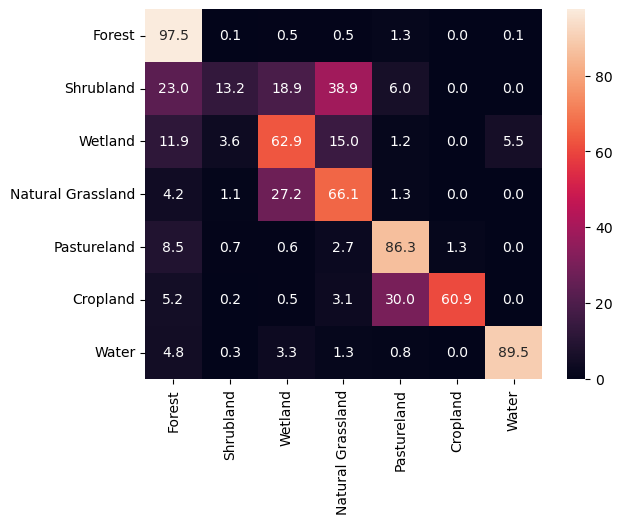

In [58]:
import seaborn as sns
df_heat = df_percentage.loc[~df_percentage.index.isin(CLASSES.keys())]

sns.heatmap(df_heat[CLASSES.values()], annot=True, fmt=".1f")